## Dataset

In [61]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.0,), (1.0,))  # Min-max normalization (0 to 1)
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [62]:
# import matplotlib.pyplot as plt

print(train_dataset[0][0].shape)
i = 3
print(train_dataset[i][0].min(), train_dataset[i][0].max())

torch.Size([1, 28, 28])
tensor(0.) tensor(1.)


## Train CVAE

In [63]:
import cvae
import importlib
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

importlib.reload(cvae) # Reload the cvae module to ensure it's up to date

model = cvae.ConvCVAEPL()

# print(hasattr(model, 'forward'))

logger = CSVLogger("logs", name="train_10_epochs")

# Initialize the PyTorch Lightning Trainer
trainer = Trainer(max_epochs=10, accelerator="auto", logger=logger)

# Ensure the data has the correct shape
for batch in train_loader:
	x, y = batch
	# print(f"Input shape: {x.shape}")  # Debugging: Print the shape of the input tensor
	# print(y[0].shape)  # Debugging: Print the shape of the label tensor
	print(x.min(), x.max())  # Debugging: Print the min and max values of the input tensor
	break

# Train the model
trainer.fit(model, train_loader, test_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | ConvCVAE | 703 K  | train
-------------------------------------------
703 K     Trainable params
0         Non-trainable params
703 K     Total params
2.816     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


tensor(0.) tensor(1.)
Beta = 0.000                                                               
Beta = 0.000                                                                                             
Beta = 0.000                                                                                             
Beta = 0.000                                                                                             
Beta = 0.000                                                                                             
Beta = 0.000                                                                                             
Beta = 0.000                                                                                             
Beta = 0.000                                                                                             
Beta = 0.000                                                                                             
Beta = 0.000                                          

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 938/938 [00:55<00:00, 16.88it/s, v_num=9, val_loss=1.72e+3, train_loss=1.58e+3]


## Plot trining progress

In [64]:
import pandas as pd
import os

metrics = pd.read_csv(os.path.join(logger.log_dir, "metrics.csv")).ffill()

In [65]:
import matplotlib.pyplot as plt

def plot_training_metrics(metrics):
    """Plot training metrics by epoch."""

    plt.plot(metrics["epoch"], metrics["train_loss"], label="Train Loss")
    plt.plot(metrics["epoch"], metrics["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss of CVAE")
    plt.grid()
    plt.legend()
    
    plt.show()

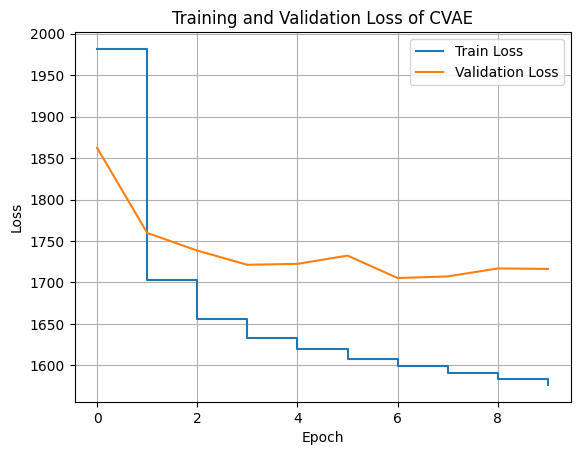

In [66]:
plot_training_metrics(metrics)

## Cluster in latent space

In [67]:
import torch

mu_list, test_labels = [], []
for image, label in test_loader:
    mu, _ = model.model.encoder(image, label)
    mu_list.append(mu)
    test_labels.append(label)

mu_array = torch.cat(mu_list, dim=0).detach().numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


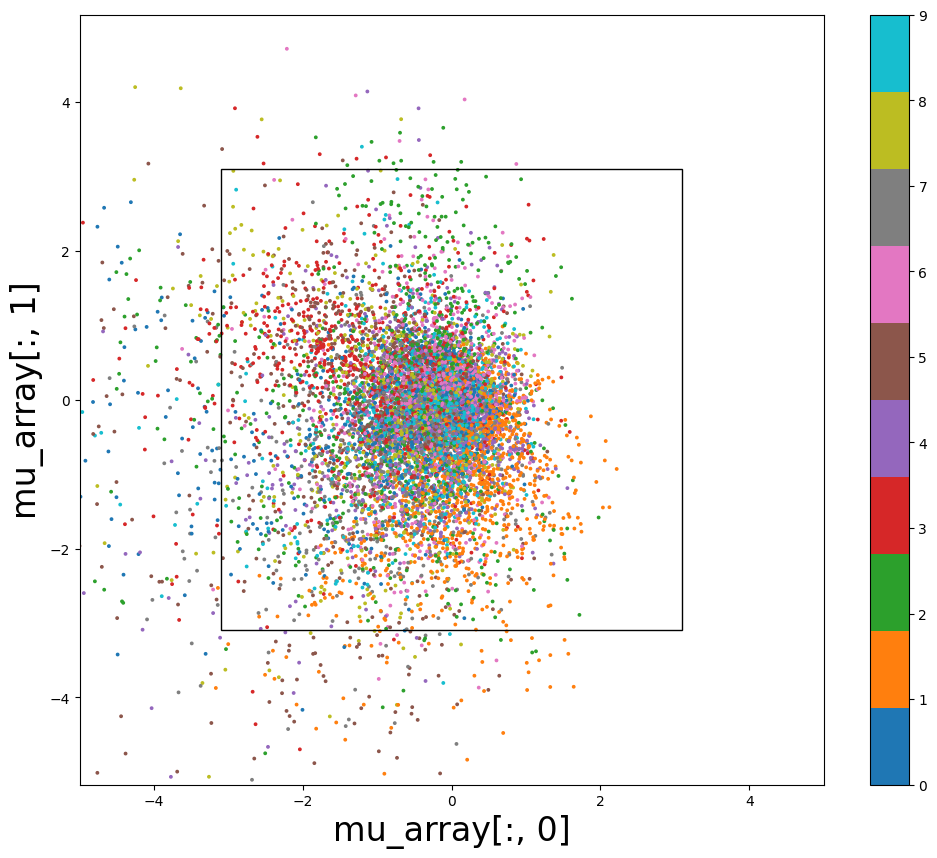

In [68]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 10))
plt.scatter(mu_array[:, 0], mu_array[:, 1], s=3, c=test_labels, cmap="tab10")
plt.gca().add_patch(Rectangle((-3.1, -3.1), 6.2, 6.2, fc="none", ec="k", lw=1))
plt.xlabel("mu_array[:, 0]", fontsize=24)
plt.ylabel("mu_array[:, 1]", fontsize=24)
plt.gca().invert_yaxis()
plt.axis("equal")
plt.colorbar()
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

## Generate/sample images

tensor([[-2.0484,  1.9397]])
tensor([8])


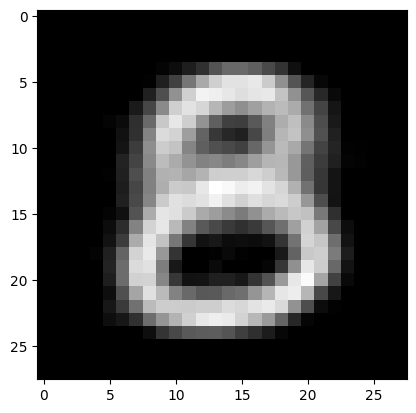

In [69]:
import numpy as np

# fake_images = gen(fix_latent_vector, fix_class_labels).detach().cpu().numpy()

label = np.array([8])
z = np.random.rand(1,2)*6-3

print(torch.from_numpy(z).float())
print(torch.from_numpy(label))

generated_images = model.model.sample(torch.from_numpy(z).float(), torch.tensor(label))

plt.imshow(generated_images[0][0].detach().cpu().numpy(), cmap="gray")
plt.show()

# fig, axs = plt.subplots(3, 10, figsize=(20, 6))
# for i, ax in enumerate(axs.ravel()):
#     ax.imshow(fake_images[i][0], cmap="gray")
#     ax.axis("off")
# plt.tight_layout()
# plt.show()
# plt.close(fig)

Epoch 0:  22%|██▏       | 205/938 [37:04<2:12:33,  0.09it/s, v_num=5]


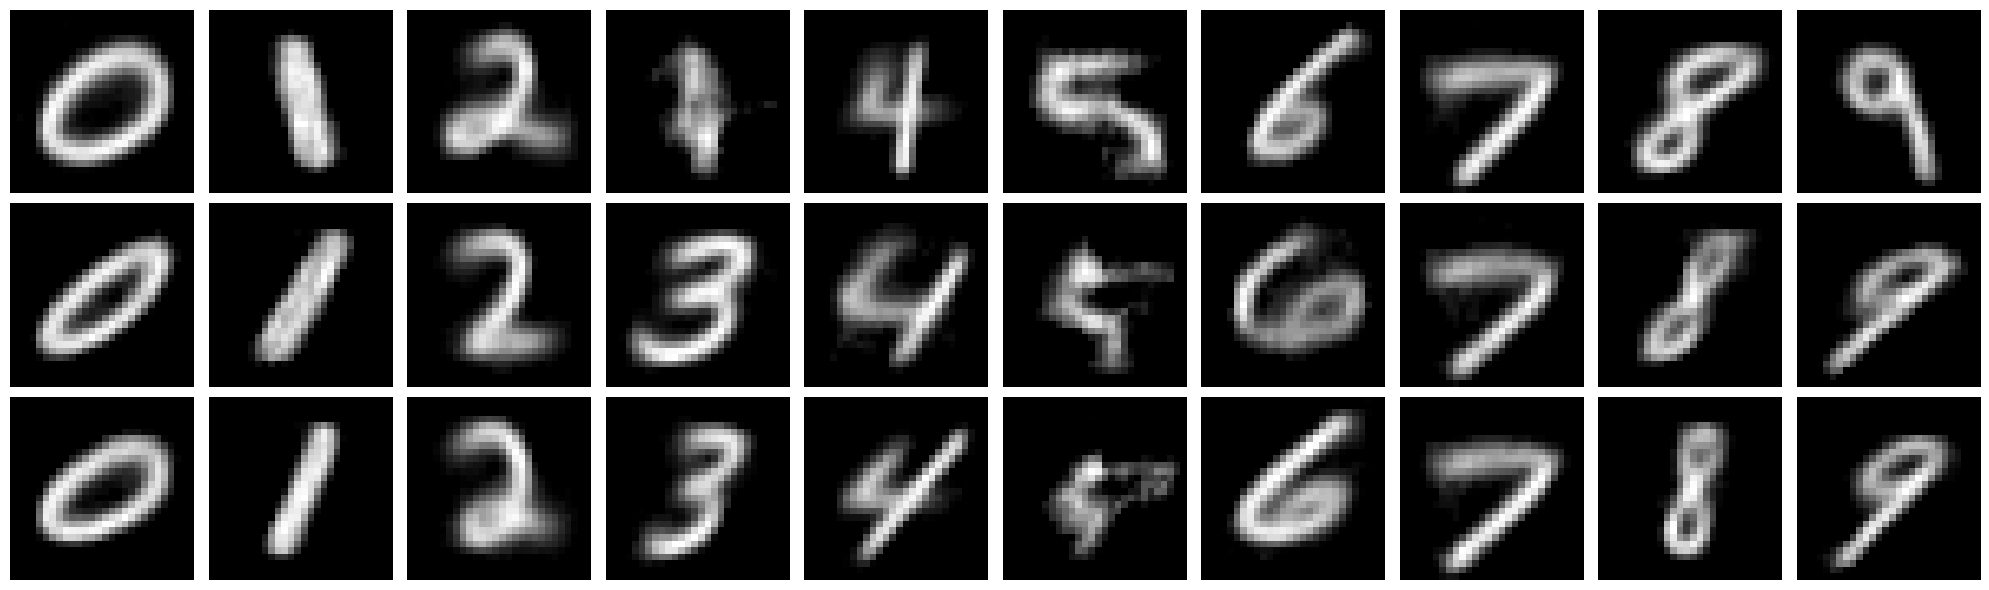

In [70]:
latent_dim = 2

fix_latent_vector = torch.randn(30, latent_dim)*2-1 # .to(device)
fix_class_labels = torch.arange(0, 10).repeat(3) # .to(device)

# print(fix_latent_vector)

generated_images = model.model.sample(fix_latent_vector, fix_class_labels)

fig, axs = plt.subplots(3, 10, figsize=(20, 6))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(generated_images[i][0].detach().cpu().numpy(), cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()
plt.close(fig)